**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
X = sorted(glob(r"D:\Sian\OneDrive - King's College London\Documents\Pragya\StarDist_training\tifs\ref_test_renamed\*.tif"))
Y = sorted(glob(r"D:\Sian\OneDrive - King's College London\Documents\Pragya\StarDist_training\tifs\labels_renamed\*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

In [4]:
for i in range(len(Y)):
    og = Y[i]
    re_typed = og.astype('uint16')
    Y[i] = re_typed

Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████████████████████████████████████████████████████████████████████████████| 84/84 [00:01<00:00, 67.85it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  84
- training:        71
- validation:      13


Training data consists of pairs of input image and label instances.

In [7]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

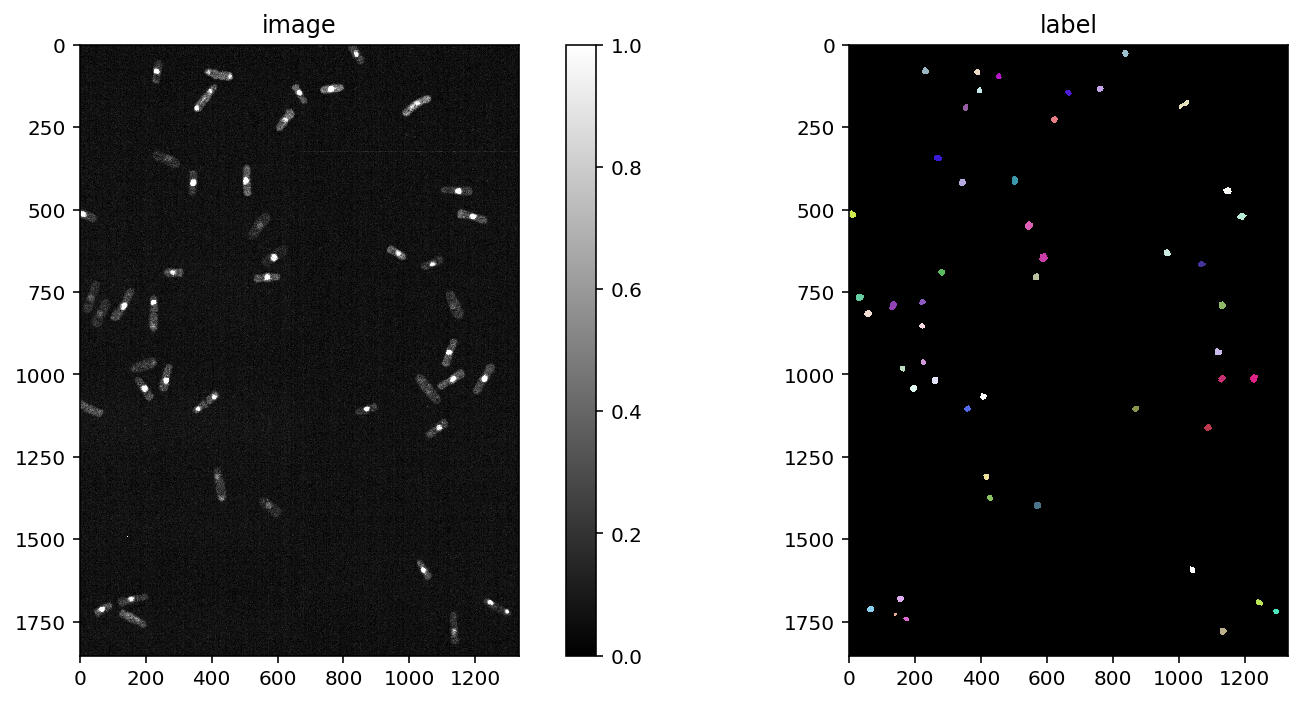

In [8]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [9]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter_base : int
        Number of convo

In [10]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [11]:
model = StarDist2D(conf, name='stardist_60x_AV1200', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [21.  20.5]
network field of view :  [92 92]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [13]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

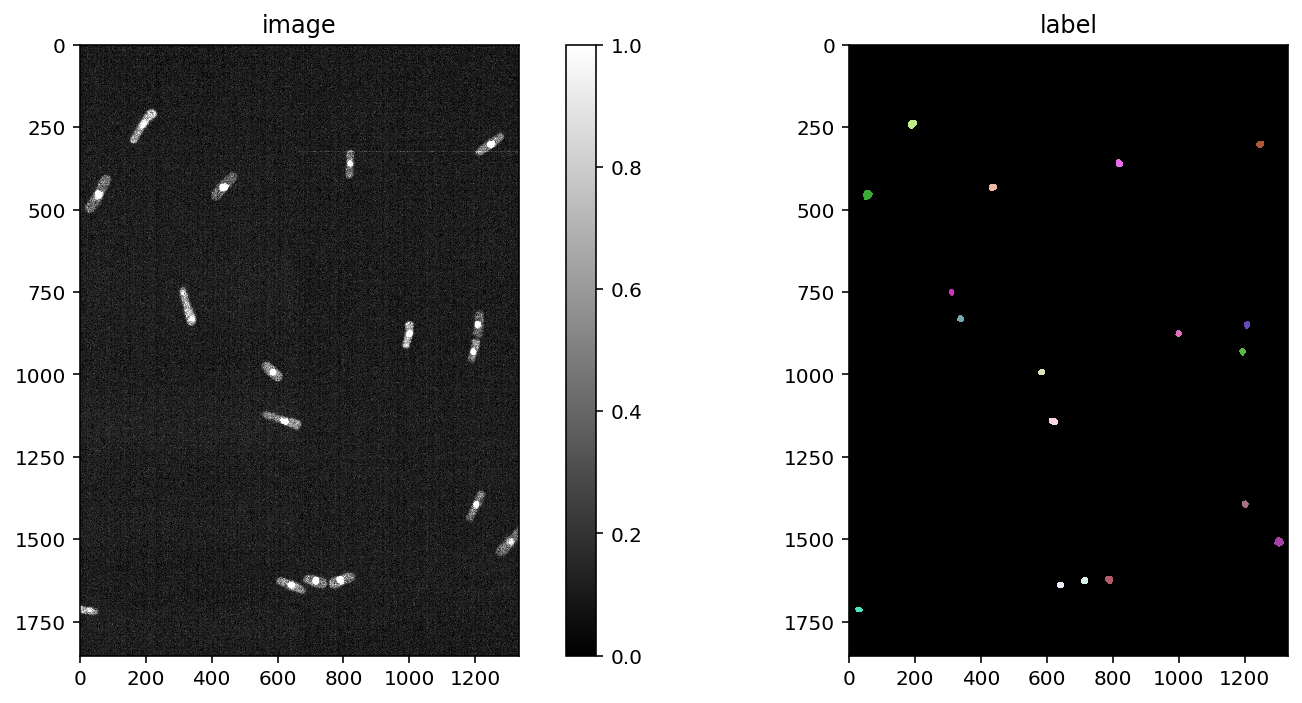

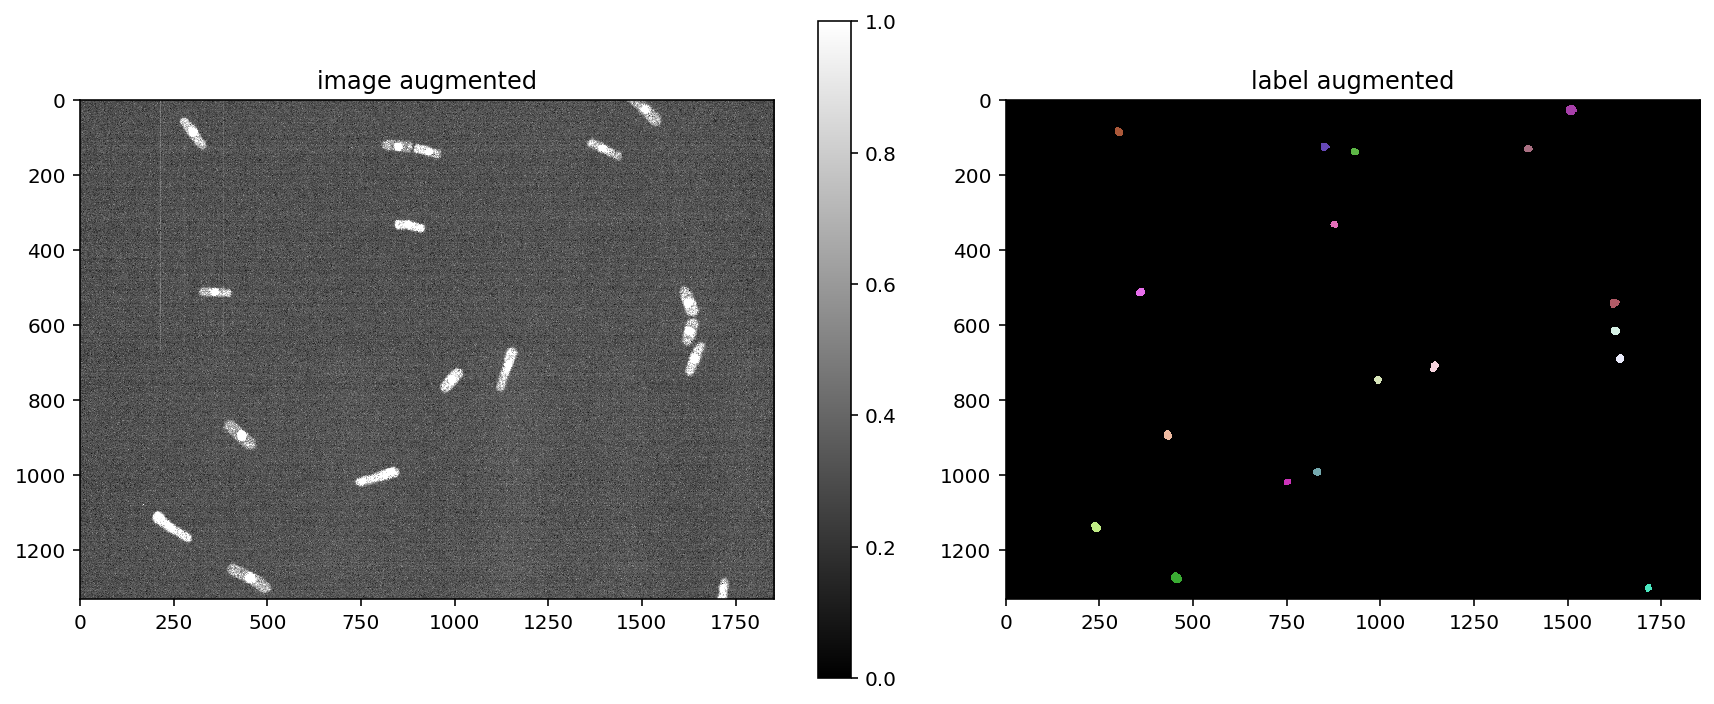

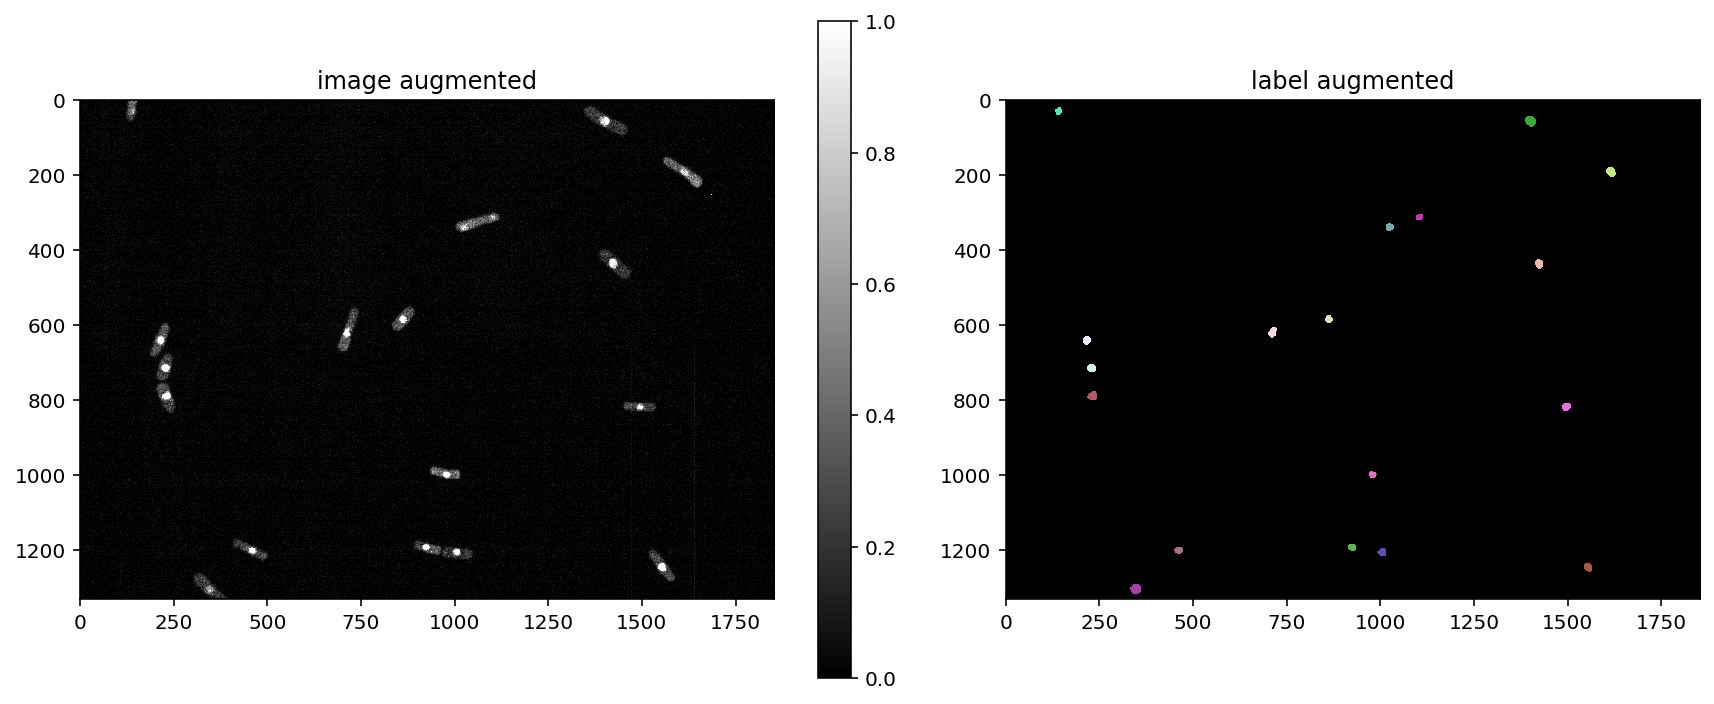

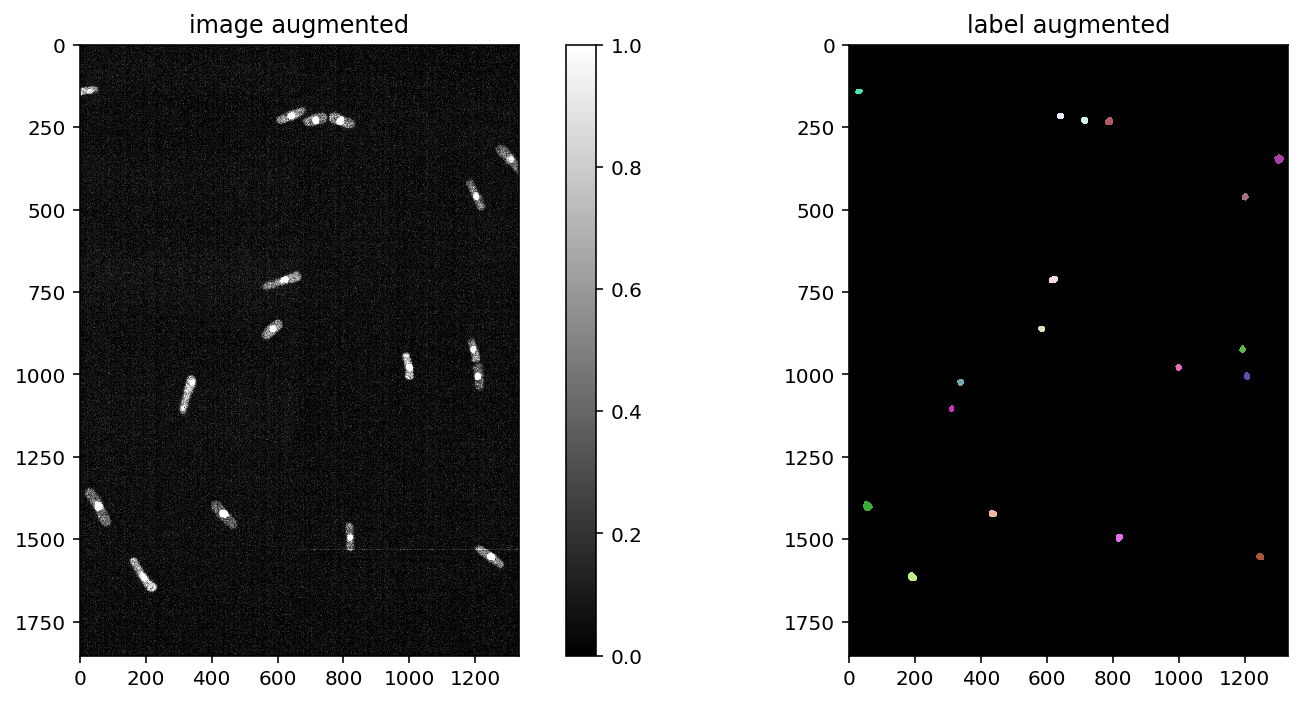

In [15]:
# plot some augmented examples
img, lbl = X[3],Y[3]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [16]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 [==============================] - 15s 153ms/step - loss: 1.2551 - prob_loss: 0.1203 - dist_loss: 5.6738 - prob_kld: 0.0968 - dist_relevant_mae: 5.6733 - dist_relevant_mse: 52.0691 - val_loss: 1.0697 - val_prob_loss: 0.0378 - val_dist_loss: 5.1594 - val_prob_kld: 0.0310 - val_dist_relevant_mae: 5.1590 - val_dist_relevant_mse: 42.5033
Epoch 2/400
100/100 [==============================] - 10s 103ms/step - loss: 0.8270 - prob_loss: 0.0308 - dist_loss: 3.9811 - prob_kld: 0.0251 - dist_relevant_mae: 3.9803 - dist_relevant_mse: 25.0093 - val_loss: 0.7925 - val_prob_loss: 0.0319 - val_dist_loss: 3.8026 - val_prob_kld: 0.0252 - val_dist_relevant_mae: 3.8017 - val_dist_relevant_mse: 22.8595
Epoch 3/400
100/100 [==============================] - 10s 98ms/step - loss: 0.7887 - prob_loss: 0.0295 - dist_loss: 3.7958 - prob_kld: 0.0238 - dist_relevant_mae: 3.7949 - dist_relevant_mse: 23.0542 - val_loss: 0.7871 - val_prob_loss: 0.0345 - val_dist_loss: 3.7629 - val_prob_kld: 0.027

Epoch 24/400
100/100 [==============================] - 9s 92ms/step - loss: 0.3460 - prob_loss: 0.0122 - dist_loss: 1.6690 - prob_kld: 0.0065 - dist_relevant_mae: 1.6682 - dist_relevant_mse: 5.3981 - val_loss: 0.3472 - val_prob_loss: 0.0129 - val_dist_loss: 1.6714 - val_prob_kld: 0.0062 - val_dist_relevant_mae: 1.6706 - val_dist_relevant_mse: 5.4172
Epoch 25/400
100/100 [==============================] - 9s 91ms/step - loss: 0.3855 - prob_loss: 0.0129 - dist_loss: 1.8626 - prob_kld: 0.0072 - dist_relevant_mae: 1.8617 - dist_relevant_mse: 6.8556 - val_loss: 0.3713 - val_prob_loss: 0.0130 - val_dist_loss: 1.7915 - val_prob_kld: 0.0062 - val_dist_relevant_mae: 1.7907 - val_dist_relevant_mse: 6.1487
Epoch 26/400
100/100 [==============================] - 9s 91ms/step - loss: 0.3414 - prob_loss: 0.0118 - dist_loss: 1.6478 - prob_kld: 0.0061 - dist_relevant_mae: 1.6469 - dist_relevant_mse: 5.4242 - val_loss: 0.3006 - val_prob_loss: 0.0131 - val_dist_loss: 1.4373 - val_prob_kld: 0.0064 - val

100/100 [==============================] - 9s 91ms/step - loss: 0.3071 - prob_loss: 0.0097 - dist_loss: 1.4871 - prob_kld: 0.0043 - dist_relevant_mae: 1.4863 - dist_relevant_mse: 4.5918 - val_loss: 0.2795 - val_prob_loss: 0.0109 - val_dist_loss: 1.3433 - val_prob_kld: 0.0041 - val_dist_relevant_mae: 1.3425 - val_dist_relevant_mse: 3.7082
Epoch 48/400
100/100 [==============================] - 9s 92ms/step - loss: 0.3171 - prob_loss: 0.0100 - dist_loss: 1.5353 - prob_kld: 0.0043 - dist_relevant_mae: 1.5345 - dist_relevant_mse: 4.8199 - val_loss: 0.2707 - val_prob_loss: 0.0109 - val_dist_loss: 1.2992 - val_prob_kld: 0.0041 - val_dist_relevant_mae: 1.2983 - val_dist_relevant_mse: 3.6502ss: 1.5477 - prob_kld: 0.0041 - dist_relevant_mae: 1.5469 - d
Epoch 49/400
100/100 [==============================] - 9s 92ms/step - loss: 0.3068 - prob_loss: 0.0103 - dist_loss: 1.4824 - prob_kld: 0.0043 - dist_relevant_mae: 1.4816 - dist_relevant_mse: 4.4384 - val_loss: 0.3019 - val_prob_loss: 0.0120 - va

100/100 [==============================] - 9s 93ms/step - loss: 0.3008 - prob_loss: 0.0095 - dist_loss: 1.4563 - prob_kld: 0.0036 - dist_relevant_mae: 1.4555 - dist_relevant_mse: 4.3189 - val_loss: 0.2810 - val_prob_loss: 0.0102 - val_dist_loss: 1.3539 - val_prob_kld: 0.0034 - val_dist_relevant_mae: 1.3531 - val_dist_relevant_mse: 3.8720
Epoch 71/400
100/100 [==============================] - 10s 96ms/step - loss: 0.2927 - prob_loss: 0.0097 - dist_loss: 1.4149 - prob_kld: 0.0038 - dist_relevant_mae: 1.4141 - dist_relevant_mse: 4.1658 - val_loss: 0.2736 - val_prob_loss: 0.0105 - val_dist_loss: 1.3157 - val_prob_kld: 0.0037 - val_dist_relevant_mae: 1.3149 - val_dist_relevant_mse: 3.6145
Epoch 72/400
100/100 [==============================] - 10s 95ms/step - loss: 0.3035 - prob_loss: 0.0092 - dist_loss: 1.4717 - prob_kld: 0.0035 - dist_relevant_mae: 1.4708 - dist_relevant_mse: 4.2659 - val_loss: 0.2758 - val_prob_loss: 0.0100 - val_dist_loss: 1.3293 - val_prob_kld: 0.0032 - val_dist_relev

100/100 [==============================] - 9s 92ms/step - loss: 0.2862 - prob_loss: 0.0097 - dist_loss: 1.3828 - prob_kld: 0.0038 - dist_relevant_mae: 1.3820 - dist_relevant_mse: 4.0387 - val_loss: 0.2662 - val_prob_loss: 0.0100 - val_dist_loss: 1.2812 - val_prob_kld: 0.0032 - val_dist_relevant_mae: 1.2803 - val_dist_relevant_mse: 3.4666
Epoch 94/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2855 - prob_loss: 0.0096 - dist_loss: 1.3793 - prob_kld: 0.0038 - dist_relevant_mae: 1.3785 - dist_relevant_mse: 3.9726 - val_loss: 0.2602 - val_prob_loss: 0.0100 - val_dist_loss: 1.2509 - val_prob_kld: 0.0033 - val_dist_relevant_mae: 1.2501 - val_dist_relevant_mse: 3.4094
Epoch 95/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2908 - prob_loss: 0.0099 - dist_loss: 1.4046 - prob_kld: 0.0040 - dist_relevant_mae: 1.4037 - dist_relevant_mse: 4.1276 - val_loss: 0.2693 - val_prob_loss: 0.0103 - val_dist_loss: 1.2946 - val_prob_kld: 0.0036 - val_dist_relevan

Epoch 116/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2854 - prob_loss: 0.0096 - dist_loss: 1.3792 - prob_kld: 0.0036 - dist_relevant_mae: 1.3784 - dist_relevant_mse: 4.1228 - val_loss: 0.2605 - val_prob_loss: 0.0096 - val_dist_loss: 1.2548 - val_prob_kld: 0.0028 - val_dist_relevant_mae: 1.2540 - val_dist_relevant_mse: 3.4026
Epoch 117/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2794 - prob_loss: 0.0094 - dist_loss: 1.3502 - prob_kld: 0.0033 - dist_relevant_mae: 1.3493 - dist_relevant_mse: 3.6762 - val_loss: 0.2471 - val_prob_loss: 0.0092 - val_dist_loss: 1.1891 - val_prob_kld: 0.0025 - val_dist_relevant_mae: 1.1882 - val_dist_relevant_mse: 3.1727
Epoch 118/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2846 - prob_loss: 0.0091 - dist_loss: 1.3775 - prob_kld: 0.0032 - dist_relevant_mae: 1.3767 - dist_relevant_mse: 3.8798 - val_loss: 0.2547 - val_prob_loss: 0.0099 - val_dist_loss: 1.2240 - val_prob_kld: 0.0032 - 

100/100 [==============================] - 9s 92ms/step - loss: 0.2793 - prob_loss: 0.0098 - dist_loss: 1.3478 - prob_kld: 0.0038 - dist_relevant_mae: 1.3469 - dist_relevant_mse: 3.9448 - val_loss: 0.2569 - val_prob_loss: 0.0098 - val_dist_loss: 1.2357 - val_prob_kld: 0.0030 - val_dist_relevant_mae: 1.2348 - val_dist_relevant_mse: 3.6309
Epoch 139/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2837 - prob_loss: 0.0090 - dist_loss: 1.3732 - prob_kld: 0.0034 - dist_relevant_mae: 1.3724 - dist_relevant_mse: 4.0401 - val_loss: 0.2735 - val_prob_loss: 0.0099 - val_dist_loss: 1.3184 - val_prob_kld: 0.0031 - val_dist_relevant_mae: 1.3175 - val_dist_relevant_mse: 3.5998
Epoch 140/400
100/100 [==============================] - 9s 93ms/step - loss: 0.2700 - prob_loss: 0.0088 - dist_loss: 1.3059 - prob_kld: 0.0027 - dist_relevant_mae: 1.3050 - dist_relevant_mse: 3.7650 - val_loss: 0.2602 - val_prob_loss: 0.0095 - val_dist_loss: 1.2534 - val_prob_kld: 0.0028 - val_dist_relev

Epoch 161/400
100/100 [==============================] - 9s 87ms/step - loss: 0.2727 - prob_loss: 0.0088 - dist_loss: 1.3194 - prob_kld: 0.0032 - dist_relevant_mae: 1.3186 - dist_relevant_mse: 3.6614 - val_loss: 0.2390 - val_prob_loss: 0.0089 - val_dist_loss: 1.1504 - val_prob_kld: 0.0022 - val_dist_relevant_mae: 1.1495 - val_dist_relevant_mse: 2.8686
Epoch 162/400
100/100 [==============================] - 9s 89ms/step - loss: 0.2688 - prob_loss: 0.0091 - dist_loss: 1.2983 - prob_kld: 0.0031 - dist_relevant_mae: 1.2975 - dist_relevant_mse: 3.5979 - val_loss: 0.2606 - val_prob_loss: 0.0093 - val_dist_loss: 1.2567 - val_prob_kld: 0.0025 - val_dist_relevant_mae: 1.2559 - val_dist_relevant_mse: 3.3947
Epoch 163/400
100/100 [==============================] - 9s 89ms/step - loss: 0.2765 - prob_loss: 0.0096 - dist_loss: 1.3347 - prob_kld: 0.0034 - dist_relevant_mae: 1.3339 - dist_relevant_mse: 3.7708 - val_loss: 0.2536 - val_prob_loss: 0.0091 - val_dist_loss: 1.2223 - val_prob_kld: 0.0024 - 

100/100 [==============================] - 9s 88ms/step - loss: 0.2743 - prob_loss: 0.0086 - dist_loss: 1.3283 - prob_kld: 0.0029 - dist_relevant_mae: 1.3276 - dist_relevant_mse: 3.8945 - val_loss: 0.2544 - val_prob_loss: 0.0089 - val_dist_loss: 1.2272 - val_prob_kld: 0.0022 - val_dist_relevant_mae: 1.2265 - val_dist_relevant_mse: 3.3926
Epoch 185/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2855 - prob_loss: 0.0094 - dist_loss: 1.3808 - prob_kld: 0.0033 - dist_relevant_mae: 1.3801 - dist_relevant_mse: 3.9454 - val_loss: 0.2882 - val_prob_loss: 0.0090 - val_dist_loss: 1.3959 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 1.3953 - val_dist_relevant_mse: 3.8540
Epoch 186/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2671 - prob_loss: 0.0088 - dist_loss: 1.2912 - prob_kld: 0.0029 - dist_relevant_mae: 1.2904 - dist_relevant_mse: 3.6191 - val_loss: 0.2451 - val_prob_loss: 0.0089 - val_dist_loss: 1.1813 - val_prob_kld: 0.0021 - val_dist_relev

Epoch 206/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2577 - prob_loss: 0.0086 - dist_loss: 1.2458 - prob_kld: 0.0027 - dist_relevant_mae: 1.2451 - dist_relevant_mse: 3.4045 - val_loss: 0.2474 - val_prob_loss: 0.0088 - val_dist_loss: 1.1930 - val_prob_kld: 0.0021 - val_dist_relevant_mae: 1.1923 - val_dist_relevant_mse: 3.3543
Epoch 207/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2611 - prob_loss: 0.0090 - dist_loss: 1.2604 - prob_kld: 0.0030 - dist_relevant_mae: 1.2597 - dist_relevant_mse: 3.5240 - val_loss: 0.2510 - val_prob_loss: 0.0090 - val_dist_loss: 1.2099 - val_prob_kld: 0.0022 - val_dist_relevant_mae: 1.2092 - val_dist_relevant_mse: 3.3846
Epoch 208/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2482 - prob_loss: 0.0083 - dist_loss: 1.1996 - prob_kld: 0.0025 - dist_relevant_mae: 1.1989 - dist_relevant_mse: 3.1220 - val_loss: 0.2415 - val_prob_loss: 0.0088 - val_dist_loss: 1.1635 - val_prob_kld: 0.0020 - 

Epoch 229/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2548 - prob_loss: 0.0083 - dist_loss: 1.2325 - prob_kld: 0.0025 - dist_relevant_mae: 1.2319 - dist_relevant_mse: 3.3103 - val_loss: 0.2403 - val_prob_loss: 0.0090 - val_dist_loss: 1.1567 - val_prob_kld: 0.0022 - val_dist_relevant_mae: 1.1560 - val_dist_relevant_mse: 3.0955
Epoch 230/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2511 - prob_loss: 0.0088 - dist_loss: 1.2118 - prob_kld: 0.0027 - dist_relevant_mae: 1.2111 - dist_relevant_mse: 3.2751 - val_loss: 0.2398 - val_prob_loss: 0.0087 - val_dist_loss: 1.1554 - val_prob_kld: 0.0020 - val_dist_relevant_mae: 1.1546 - val_dist_relevant_mse: 3.1686
Epoch 231/400
100/100 [==============================] - 9s 94ms/step - loss: 0.2486 - prob_loss: 0.0089 - dist_loss: 1.1986 - prob_kld: 0.0025 - dist_relevant_mae: 1.1979 - dist_relevant_mse: 3.1276 - val_loss: 0.2566 - val_prob_loss: 0.0089 - val_dist_loss: 1.2388 - val_prob_kld: 0.0021 - 

100/100 [==============================] - 9s 92ms/step - loss: 0.2440 - prob_loss: 0.0087 - dist_loss: 1.1761 - prob_kld: 0.0028 - dist_relevant_mae: 1.1755 - dist_relevant_mse: 3.0054 - val_loss: 0.2321 - val_prob_loss: 0.0089 - val_dist_loss: 1.1164 - val_prob_kld: 0.0021 - val_dist_relevant_mae: 1.1157 - val_dist_relevant_mse: 2.8815
Epoch 253/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2446 - prob_loss: 0.0083 - dist_loss: 1.1816 - prob_kld: 0.0026 - dist_relevant_mae: 1.1810 - dist_relevant_mse: 3.0826 - val_loss: 0.2410 - val_prob_loss: 0.0088 - val_dist_loss: 1.1610 - val_prob_kld: 0.0021 - val_dist_relevant_mae: 1.1604 - val_dist_relevant_mse: 3.0200
Epoch 254/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2524 - prob_loss: 0.0086 - dist_loss: 1.2192 - prob_kld: 0.0027 - dist_relevant_mae: 1.2185 - dist_relevant_mse: 3.2986 - val_loss: 0.2432 - val_prob_loss: 0.0088 - val_dist_loss: 1.1721 - val_prob_kld: 0.0020 - val_dist_relev

100/100 [==============================] - 9s 91ms/step - loss: 0.2492 - prob_loss: 0.0082 - dist_loss: 1.2048 - prob_kld: 0.0026 - dist_relevant_mae: 1.2041 - dist_relevant_mse: 3.0358 - val_loss: 0.2387 - val_prob_loss: 0.0088 - val_dist_loss: 1.1494 - val_prob_kld: 0.0020 - val_dist_relevant_mae: 1.1487 - val_dist_relevant_mse: 3.1402
Epoch 276/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2652 - prob_loss: 0.0094 - dist_loss: 1.2790 - prob_kld: 0.0034 - dist_relevant_mae: 1.2783 - dist_relevant_mse: 3.5643 - val_loss: 0.2483 - val_prob_loss: 0.0091 - val_dist_loss: 1.1960 - val_prob_kld: 0.0024 - val_dist_relevant_mae: 1.1953 - val_dist_relevant_mse: 3.2987
Epoch 277/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2520 - prob_loss: 0.0084 - dist_loss: 1.2180 - prob_kld: 0.0027 - dist_relevant_mae: 1.2173 - dist_relevant_mse: 3.2604 - val_loss: 0.2421 - val_prob_loss: 0.0087 - val_dist_loss: 1.1669 - val_prob_kld: 0.0020 - val_dist_relev

100/100 [==============================] - 9s 94ms/step - loss: 0.2492 - prob_loss: 0.0086 - dist_loss: 1.2030 - prob_kld: 0.0025 - dist_relevant_mae: 1.2024 - dist_relevant_mse: 3.1258 - val_loss: 0.2300 - val_prob_loss: 0.0086 - val_dist_loss: 1.1074 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.1067 - val_dist_relevant_mse: 2.9476
Epoch 298/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2536 - prob_loss: 0.0082 - dist_loss: 1.2274 - prob_kld: 0.0025 - dist_relevant_mae: 1.2267 - dist_relevant_mse: 3.4561 - val_loss: 0.2434 - val_prob_loss: 0.0087 - val_dist_loss: 1.1738 - val_prob_kld: 0.0019 - val_dist_relevant_mae: 1.1731 - val_dist_relevant_mse: 3.1349
Epoch 299/400
100/100 [==============================] - 10s 97ms/step - loss: 0.2436 - prob_loss: 0.0088 - dist_loss: 1.1742 - prob_kld: 0.0026 - dist_relevant_mae: 1.1735 - dist_relevant_mse: 3.1766 - val_loss: 0.2257 - val_prob_loss: 0.0086 - val_dist_loss: 1.0853 - val_prob_kld: 0.0019 - val_dist_rele

100/100 [==============================] - 9s 92ms/step - loss: 0.2438 - prob_loss: 0.0087 - dist_loss: 1.1757 - prob_kld: 0.0027 - dist_relevant_mae: 1.1751 - dist_relevant_mse: 3.1775 - val_loss: 0.2329 - val_prob_loss: 0.0086 - val_dist_loss: 1.1218 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.1211 - val_dist_relevant_mse: 2.9966
Epoch 320/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2491 - prob_loss: 0.0090 - dist_loss: 1.2004 - prob_kld: 0.0030 - dist_relevant_mae: 1.1997 - dist_relevant_mse: 3.3314 - val_loss: 0.2341 - val_prob_loss: 0.0085 - val_dist_loss: 1.1282 - val_prob_kld: 0.0017 - val_dist_relevant_mae: 1.1275 - val_dist_relevant_mse: 3.0319
Epoch 321/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2362 - prob_loss: 0.0078 - dist_loss: 1.1420 - prob_kld: 0.0022 - dist_relevant_mae: 1.1413 - dist_relevant_mse: 2.7706 - val_loss: 0.2290 - val_prob_loss: 0.0083 - val_dist_loss: 1.1035 - val_prob_kld: 0.0016 - val_dist_relev

100/100 [==============================] - 9s 91ms/step - loss: 0.2366 - prob_loss: 0.0088 - dist_loss: 1.1390 - prob_kld: 0.0025 - dist_relevant_mae: 1.1384 - dist_relevant_mse: 2.8089 - val_loss: 0.2271 - val_prob_loss: 0.0084 - val_dist_loss: 1.0933 - val_prob_kld: 0.0017 - val_dist_relevant_mae: 1.0926 - val_dist_relevant_mse: 2.8151
Epoch 343/400
100/100 [==============================] - 9s 94ms/step - loss: 0.2437 - prob_loss: 0.0089 - dist_loss: 1.1739 - prob_kld: 0.0026 - dist_relevant_mae: 1.1732 - dist_relevant_mse: 3.1510 - val_loss: 0.2228 - val_prob_loss: 0.0086 - val_dist_loss: 1.0711 - val_prob_kld: 0.0018 - val_dist_relevant_mae: 1.0705 - val_dist_relevant_mse: 2.7228
Epoch 344/400
100/100 [==============================] - 9s 91ms/step - loss: 0.2428 - prob_loss: 0.0079 - dist_loss: 1.1741 - prob_kld: 0.0022 - dist_relevant_mae: 1.1735 - dist_relevant_mse: 3.0315 - val_loss: 0.2328 - val_prob_loss: 0.0084 - val_dist_loss: 1.1222 - val_prob_kld: 0.0016 - val_dist_relev

Epoch 365/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2457 - prob_loss: 0.0085 - dist_loss: 1.1862 - prob_kld: 0.0025 - dist_relevant_mae: 1.1856 - dist_relevant_mse: 3.1613 - val_loss: 0.2343 - val_prob_loss: 0.0084 - val_dist_loss: 1.1296 - val_prob_kld: 0.0017 - val_dist_relevant_mae: 1.1290 - val_dist_relevant_mse: 2.8996
Epoch 366/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2418 - prob_loss: 0.0084 - dist_loss: 1.1673 - prob_kld: 0.0024 - dist_relevant_mae: 1.1667 - dist_relevant_mse: 2.9872 - val_loss: 0.2255 - val_prob_loss: 0.0083 - val_dist_loss: 1.0859 - val_prob_kld: 0.0015 - val_dist_relevant_mae: 1.0853 - val_dist_relevant_mse: 2.8194
Epoch 367/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2412 - prob_loss: 0.0082 - dist_loss: 1.1649 - prob_kld: 0.0024 - dist_relevant_mae: 1.1643 - dist_relevant_mse: 2.9683 - val_loss: 0.2283 - val_prob_loss: 0.0083 - val_dist_loss: 1.1001 - val_prob_kld: 0.0015 - 

100/100 [==============================] - 9s 91ms/step - loss: 0.2449 - prob_loss: 0.0084 - dist_loss: 1.1825 - prob_kld: 0.0026 - dist_relevant_mae: 1.1819 - dist_relevant_mse: 3.2542 - val_loss: 0.2307 - val_prob_loss: 0.0084 - val_dist_loss: 1.1115 - val_prob_kld: 0.0016 - val_dist_relevant_mae: 1.1109 - val_dist_relevant_mse: 2.8689
Epoch 388/400
100/100 [==============================] - 9s 93ms/step - loss: 0.2462 - prob_loss: 0.0085 - dist_loss: 1.1884 - prob_kld: 0.0024 - dist_relevant_mae: 1.1878 - dist_relevant_mse: 3.0919 - val_loss: 0.2297 - val_prob_loss: 0.0085 - val_dist_loss: 1.1058 - val_prob_kld: 0.0017 - val_dist_relevant_mae: 1.1052 - val_dist_relevant_mse: 2.8865
Epoch 389/400
100/100 [==============================] - 9s 92ms/step - loss: 0.2373 - prob_loss: 0.0081 - dist_loss: 1.1461 - prob_kld: 0.0023 - dist_relevant_mae: 1.1455 - dist_relevant_mse: 2.9353 - val_loss: 0.2245 - val_prob_loss: 0.0084 - val_dist_loss: 1.0803 - val_prob_kld: 0.0017 - val_dist_relev

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [17]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|█████████████████████████████████▊           | 15/20 [01:17<00:25,  5.17s/it, 0.587 -> 0.900]


Using optimized values: prob_thresh=0.587421, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [17]:
# help(matching)

First predict the labels for all validation images:

In [18]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.28s/it]


Plot a GT/prediction example 

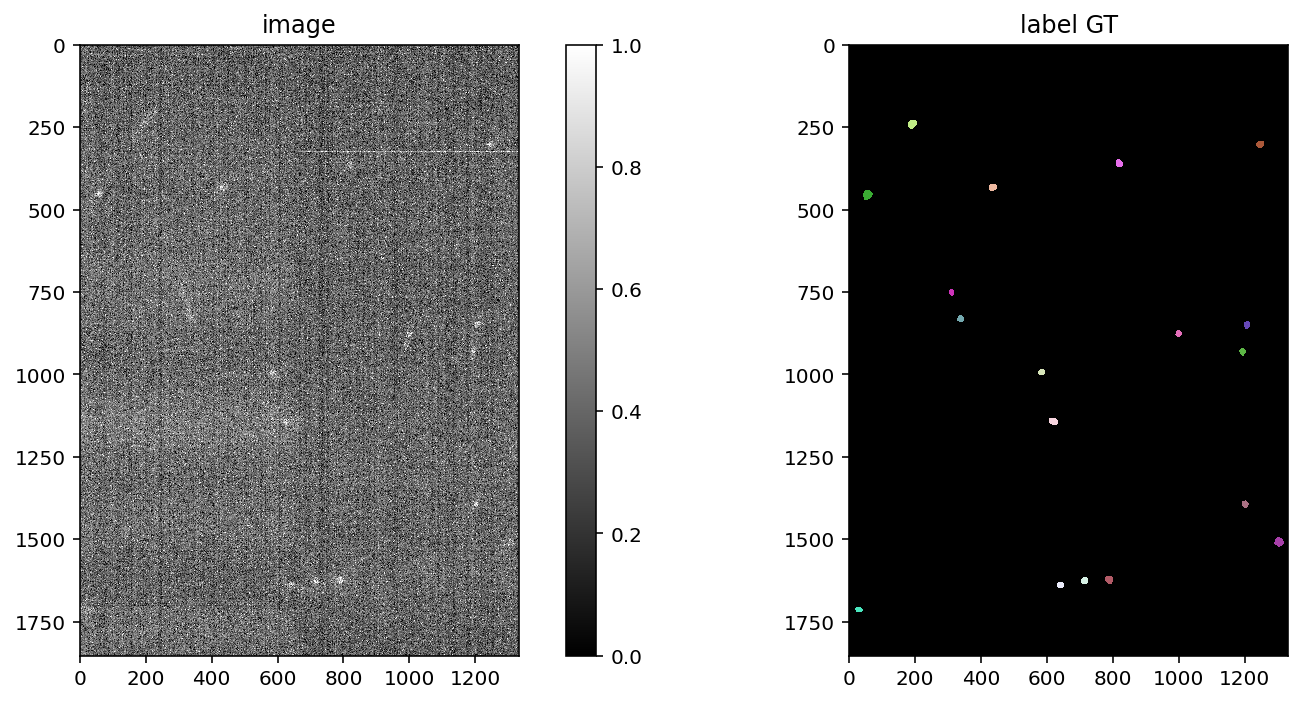

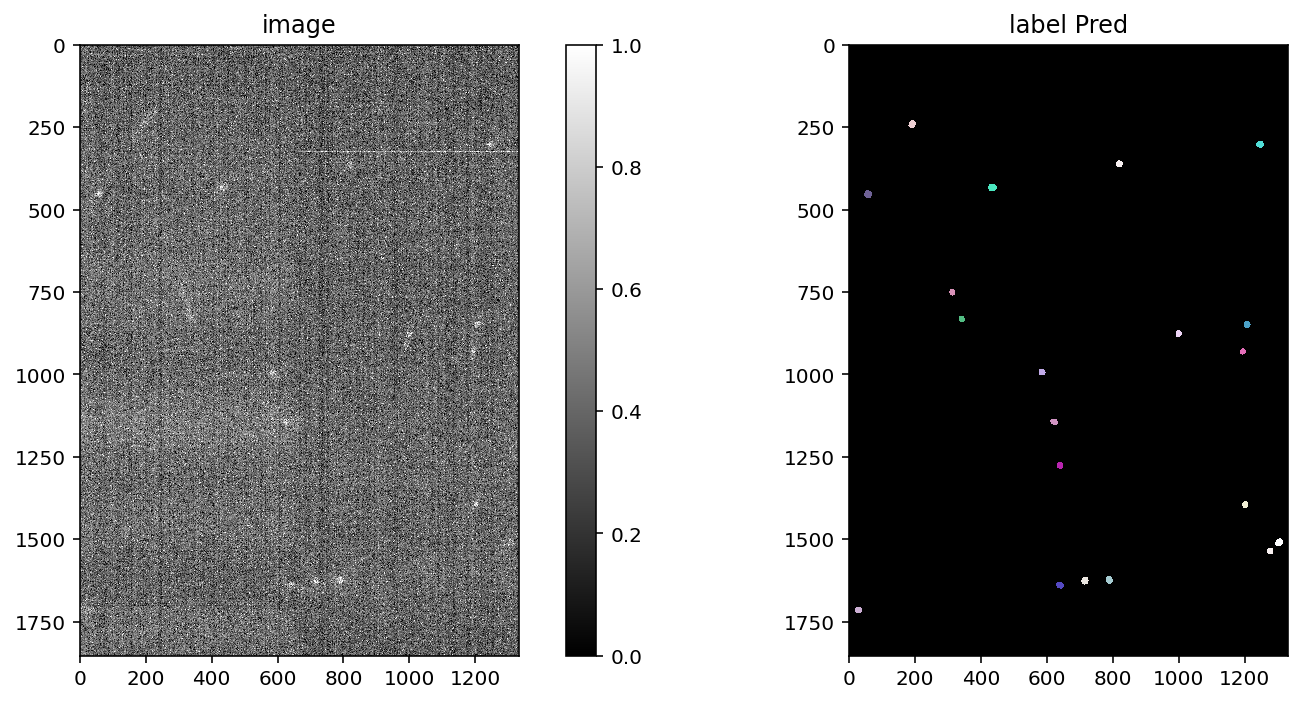

In [20]:
test_no = 1
plot_img_label(X_val[test_no],Y_val[test_no], lbl_title="label GT")
plot_img_label(X_val[test_no],Y_val_pred[test_no], lbl_title="label Pred")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [21]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.13s/it]


Example: Print all available matching statistics for $\tau=0.5$

In [22]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=25, tp=984, fn=58, precision=0.9752229930624381, recall=0.944337811900192, accuracy=0.922211808809747, f1=0.9595319356411507, n_true=1042, n_pred=1009, mean_true_score=0.8084029687450015, mean_matched_score=0.8560527372279386, panoptic_quality=0.8214099399632293, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

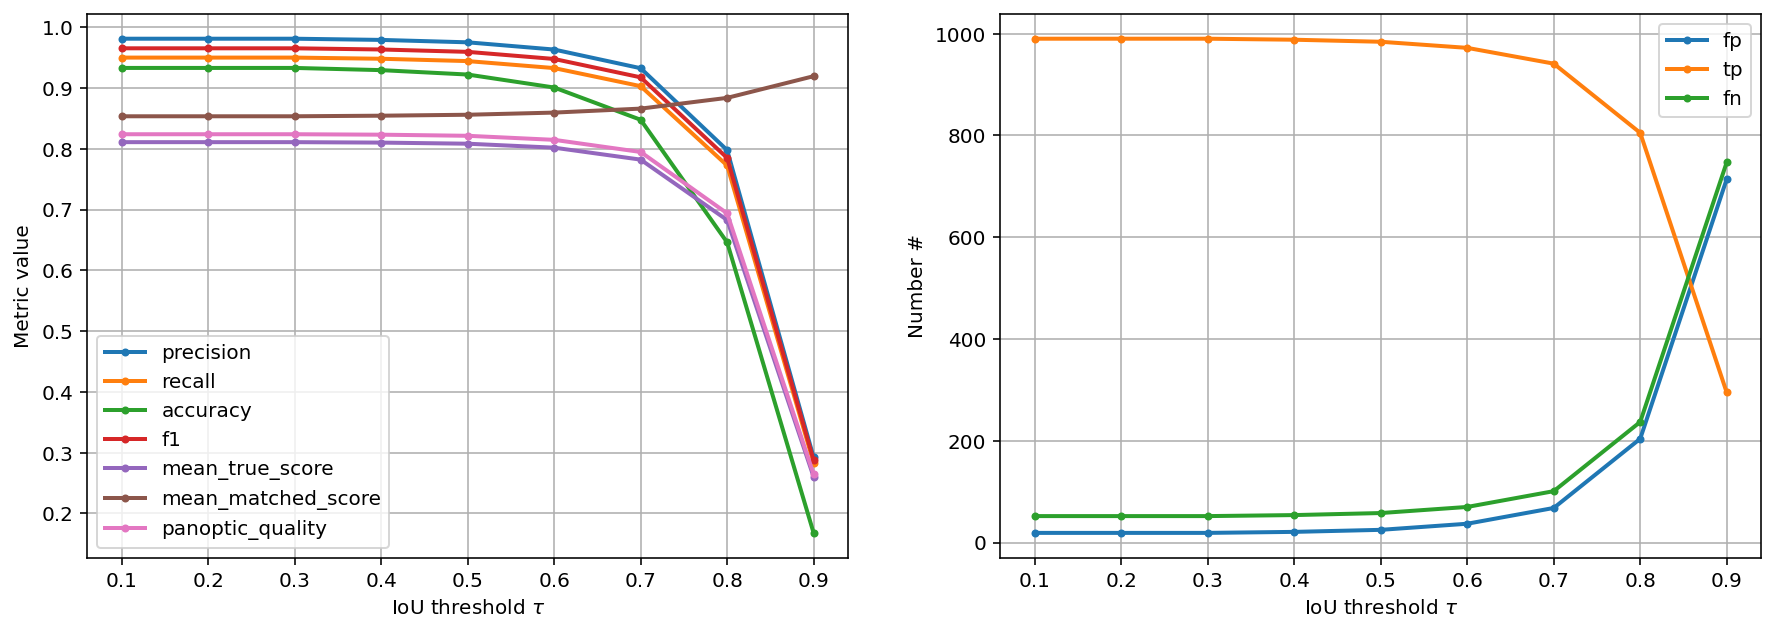

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [24]:
model.export_TF()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\SC\AppData\Local\Temp\tmp6sl2gdke\model\saved_model.pb


C:\Users\SC\Anaconda3\envs\csbdeep\lib\site-packages\csbdeep\utils\tf.py:265: UserWarning: 
***IMPORTANT NOTE***

You are using 'tensorflow' 2.x, hence it is likely that the exported model *will not work*
in associated ImageJ/Fiji plugins (e.g. CSBDeep and StarDist).

If you indeed have problems loading the exported model in Fiji, the current workaround is
to load the trained model in a Python environment with installed 'tensorflow' 1.x and then
export it again. If you need help with this, please read:

https://gist.github.com/uschmidt83/4b747862fe307044c722d6d1009f6183

  """)
